In [13]:
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = Planetoid(root="", name="PubMed", split="public")
dataset

Processing...
Done!


PubMed()

In [3]:
print("No of graphs in dataset: ", len(dataset))

No of graphs in dataset:  1


In [4]:
data = dataset[0]
print(data)

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


In [5]:
#Print information about the dataset

print(f'Dataset: {dataset}')
print('---------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: PubMed()
---------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3


In [6]:
# let's check the number of unique nodes in the train, test and validation split

total_nodes = dataset[0].num_nodes
unique_nodes = set(dataset[0].train_mask.nonzero().view(-1).tolist() +
                  dataset[0].test_mask.nonzero().view(-1).tolist() +
                  dataset[0].val_mask.nonzero().view(-1).tolist())
total_unique_nodes = len(unique_nodes)

print("Total Nodes:", total_nodes)
print("Total Unique Nodes Across Sets:", total_unique_nodes)

Total Nodes: 19717
Total Unique Nodes Across Sets: 1560


In [7]:
data.num_edge_features

0

In [9]:
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true).item()/len(y_true)

# GCN

In [10]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, no_in, no_hidden, no_out):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels=no_in, out_channels=no_hidden)
        self.conv2 = GCNConv(in_channels=no_hidden, out_channels=no_out)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        self.train()
        
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            
            loss = criterion(out[data.train_mask],data.y[data.train_mask]) 
            acc = accuracy(out[data.train_mask].argmax(dim=1),data.y[data.train_mask])
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            train_accuracies.append(acc)
            
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc)
            
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')
            
        test_acc = self.test(data)
        
          # After training, plot the loss and accuracy curves
        self.plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies,test_acc)
        
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc
    
    def plot_training_curves(self, train_losses, val_losses, train_accuracies, val_accuracies,test_acc):
        # Plot loss curves
        epochs = range(len(train_losses))
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        
         # Plot test accuracy as a horizontal line
        plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc*100:.2f}%')
        
        plt.title('Accuracy Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Set y-axis ticks to increments of 0.1
        plt.yticks(np.arange(0, 1.1, 0.1))

        plt.tight_layout()
        plt.show()

In [15]:
dataset.num_features

500

In [44]:
gcn = GCN(dataset.num_features,64, dataset.num_classes)
print(gcn)

GCN(
  (conv1): GCNConv(500, 64)
  (conv2): GCNConv(64, 3)
)


Epoch   0 | Train Loss: 1.098 | Train Acc: 35.00% | Val Loss: 1.10 | Val Acc: 29.40%
Epoch   1 | Train Loss: 1.076 | Train Acc: 81.67% | Val Loss: 1.09 | Val Acc: 62.20%
Epoch   2 | Train Loss: 1.049 | Train Acc: 88.33% | Val Loss: 1.07 | Val Acc: 69.40%
Epoch   3 | Train Loss: 1.014 | Train Acc: 86.67% | Val Loss: 1.05 | Val Acc: 68.00%
Epoch   4 | Train Loss: 0.975 | Train Acc: 83.33% | Val Loss: 1.03 | Val Acc: 68.80%
Epoch   5 | Train Loss: 0.940 | Train Acc: 90.00% | Val Loss: 1.01 | Val Acc: 68.60%
Epoch   6 | Train Loss: 0.897 | Train Acc: 91.67% | Val Loss: 0.99 | Val Acc: 69.20%
Epoch   7 | Train Loss: 0.852 | Train Acc: 90.00% | Val Loss: 0.96 | Val Acc: 71.80%
Epoch   8 | Train Loss: 0.814 | Train Acc: 93.33% | Val Loss: 0.93 | Val Acc: 72.20%
Epoch   9 | Train Loss: 0.762 | Train Acc: 93.33% | Val Loss: 0.90 | Val Acc: 72.60%
Epoch  10 | Train Loss: 0.719 | Train Acc: 95.00% | Val Loss: 0.87 | Val Acc: 73.80%
Epoch  11 | Train Loss: 0.671 | Train Acc: 91.67% | Val Loss: 0.8

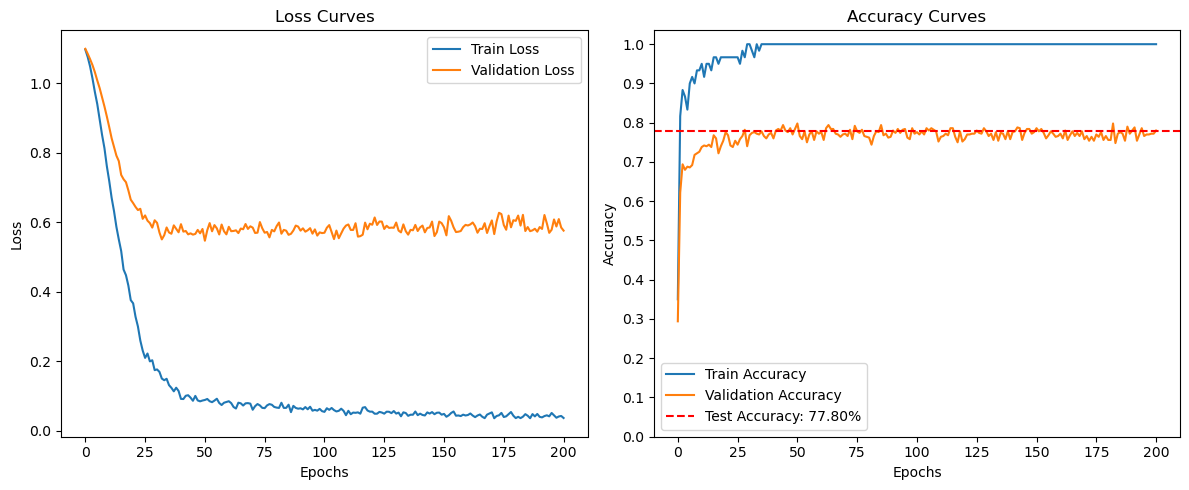

In [45]:
gcn.fit(data.cpu(), epochs=200)

In [46]:
gcn.test(data.cpu())

0.778

In [47]:
gcn_gpu = GCN(dataset.num_features, 64, dataset.num_classes).to('mps')
gcn_gpu

GCN(
  (conv1): GCNConv(500, 64)
  (conv2): GCNConv(64, 3)
)

Epoch   0 | Train Loss: 1.098 | Train Acc: 30.00% | Val Loss: 1.10 | Val Acc: 28.40%
Epoch   1 | Train Loss: 1.076 | Train Acc: 63.33% | Val Loss: 1.09 | Val Acc: 53.00%
Epoch   2 | Train Loss: 1.049 | Train Acc: 85.00% | Val Loss: 1.07 | Val Acc: 63.40%
Epoch   3 | Train Loss: 1.018 | Train Acc: 90.00% | Val Loss: 1.05 | Val Acc: 69.20%
Epoch   4 | Train Loss: 0.979 | Train Acc: 95.00% | Val Loss: 1.03 | Val Acc: 68.60%
Epoch   5 | Train Loss: 0.941 | Train Acc: 91.67% | Val Loss: 1.01 | Val Acc: 69.80%
Epoch   6 | Train Loss: 0.902 | Train Acc: 90.00% | Val Loss: 0.98 | Val Acc: 68.20%
Epoch   7 | Train Loss: 0.863 | Train Acc: 90.00% | Val Loss: 0.95 | Val Acc: 71.20%
Epoch   8 | Train Loss: 0.813 | Train Acc: 91.67% | Val Loss: 0.93 | Val Acc: 72.00%
Epoch   9 | Train Loss: 0.768 | Train Acc: 90.00% | Val Loss: 0.90 | Val Acc: 72.40%
Epoch  10 | Train Loss: 0.707 | Train Acc: 93.33% | Val Loss: 0.87 | Val Acc: 73.20%
Epoch  11 | Train Loss: 0.674 | Train Acc: 95.00% | Val Loss: 0.8

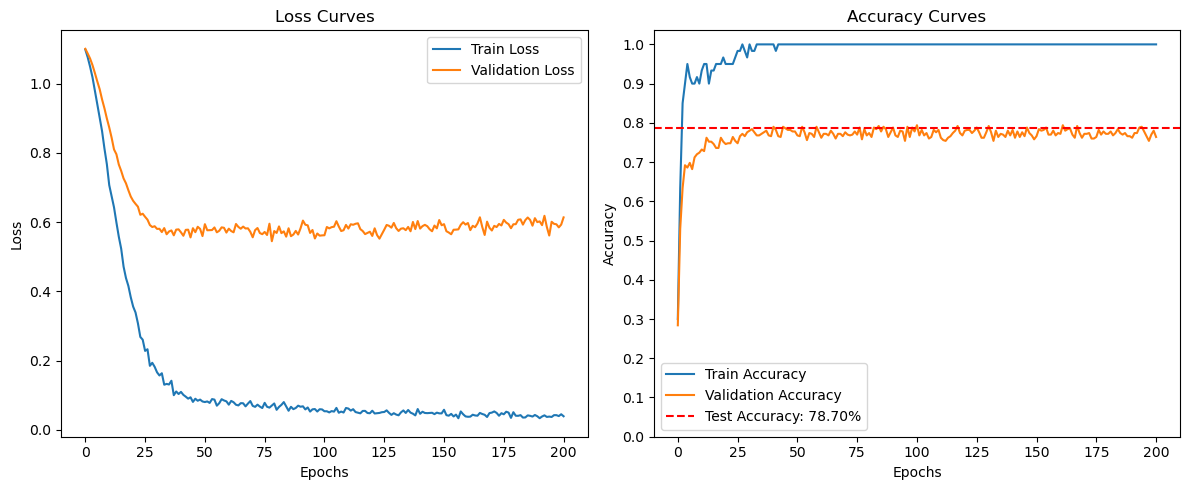

In [48]:
gcn_gpu.fit(data.to('mps'), epochs=200)

In [49]:
gcn_gpu.test(data.to('mps'))

0.787

f## Summary of GCN

| Device  |  Train Acc  | Val Acc | Test Acc |
|:-------:|:-----------:|:-------:|:--------:|
|   CPU   |    100%     |  75.8%  |  78.6%   |
|   GPU   |    100%     |  77.8%  |  79.1%   |

# GraphSAGE

In [28]:
from torch_geometric.nn import SAGEConv

In [37]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.conv1 = SAGEConv(dim_in, dim_h, aggr="mean")
        self.conv2 = SAGEConv(dim_h, dim_out, aggr="mean")
    
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, training=self.training)
        h = self.conv2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            train_accuracies.append(acc)
            
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            
            val_losses.append(val_loss.item())
            val_accuracies.append(val_acc)
            
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')
        
        test_acc = self.test(data)
        
          # After training, plot the loss and accuracy curves
        self.plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies,test_acc)
        
    
    def plot_training_curves(self, train_losses, val_losses, train_accuracies, val_accuracies,test_acc):
        # Plot loss curves
        epochs = range(len(train_losses))
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Loss Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        
         # Plot test accuracy as a horizontal line
        plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc*100:.2f}%')
        
        plt.title('Accuracy Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Set y-axis ticks to increments of 0.1
        plt.yticks(np.arange(0, 1.1, 0.1))

        plt.tight_layout()
        plt.show()
    
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc
    

In [38]:
g_sage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
g_sage

GraphSAGE(
  (conv1): SAGEConv(500, 64, aggr=mean)
  (conv2): SAGEConv(64, 3, aggr=mean)
)

Epoch   0 | Train Loss: 1.105 | Train Acc: 33.33% | Val Loss: 1.12 | Val Acc: 19.60%
Epoch   1 | Train Loss: 1.075 | Train Acc: 38.33% | Val Loss: 1.10 | Val Acc: 21.40%
Epoch   2 | Train Loss: 1.037 | Train Acc: 73.33% | Val Loss: 1.08 | Val Acc: 44.60%
Epoch   3 | Train Loss: 1.000 | Train Acc: 91.67% | Val Loss: 1.05 | Val Acc: 64.80%
Epoch   4 | Train Loss: 0.937 | Train Acc: 95.00% | Val Loss: 1.02 | Val Acc: 69.20%
Epoch   5 | Train Loss: 0.868 | Train Acc: 95.00% | Val Loss: 0.99 | Val Acc: 72.80%
Epoch   6 | Train Loss: 0.791 | Train Acc: 95.00% | Val Loss: 0.95 | Val Acc: 72.20%
Epoch   7 | Train Loss: 0.721 | Train Acc: 95.00% | Val Loss: 0.91 | Val Acc: 71.40%
Epoch   8 | Train Loss: 0.640 | Train Acc: 96.67% | Val Loss: 0.87 | Val Acc: 71.80%
Epoch   9 | Train Loss: 0.552 | Train Acc: 95.00% | Val Loss: 0.83 | Val Acc: 71.20%
Epoch  10 | Train Loss: 0.500 | Train Acc: 96.67% | Val Loss: 0.80 | Val Acc: 71.60%
Epoch  11 | Train Loss: 0.403 | Train Acc: 96.67% | Val Loss: 0.7

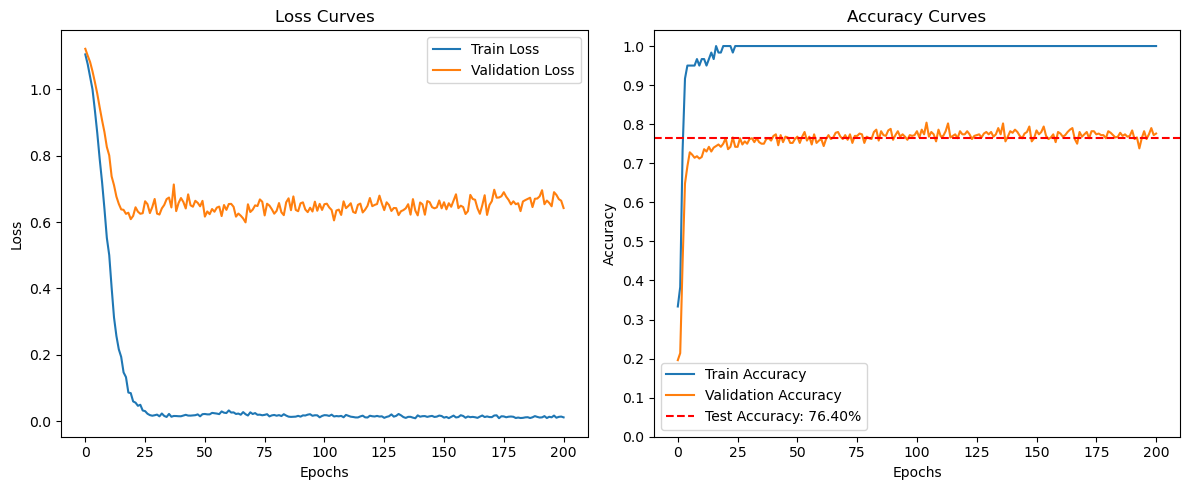

In [39]:
g_sage.fit(data.cpu(), epochs=200)

In [40]:
g_sage.test(data.cpu())

0.764

In [41]:
g_sage_gpu = GraphSAGE(dataset.num_features, 64, dataset.num_classes).to('mps')
g_sage_gpu

GraphSAGE(
  (conv1): SAGEConv(500, 64, aggr=mean)
  (conv2): SAGEConv(64, 3, aggr=mean)
)

Epoch   0 | Train Loss: 1.104 | Train Acc: 33.33% | Val Loss: 1.12 | Val Acc: 19.60%
Epoch   1 | Train Loss: 1.075 | Train Acc: 46.67% | Val Loss: 1.10 | Val Acc: 31.80%
Epoch   2 | Train Loss: 1.046 | Train Acc: 66.67% | Val Loss: 1.08 | Val Acc: 48.20%
Epoch   3 | Train Loss: 1.000 | Train Acc: 83.33% | Val Loss: 1.06 | Val Acc: 57.00%
Epoch   4 | Train Loss: 0.944 | Train Acc: 91.67% | Val Loss: 1.03 | Val Acc: 61.80%
Epoch   5 | Train Loss: 0.874 | Train Acc: 96.67% | Val Loss: 1.00 | Val Acc: 66.00%
Epoch   6 | Train Loss: 0.806 | Train Acc: 95.00% | Val Loss: 0.96 | Val Acc: 70.00%
Epoch   7 | Train Loss: 0.729 | Train Acc: 98.33% | Val Loss: 0.92 | Val Acc: 69.20%
Epoch   8 | Train Loss: 0.662 | Train Acc: 96.67% | Val Loss: 0.88 | Val Acc: 69.60%
Epoch   9 | Train Loss: 0.564 | Train Acc: 98.33% | Val Loss: 0.85 | Val Acc: 71.00%
Epoch  10 | Train Loss: 0.491 | Train Acc: 98.33% | Val Loss: 0.80 | Val Acc: 71.00%
Epoch  11 | Train Loss: 0.426 | Train Acc: 98.33% | Val Loss: 0.7

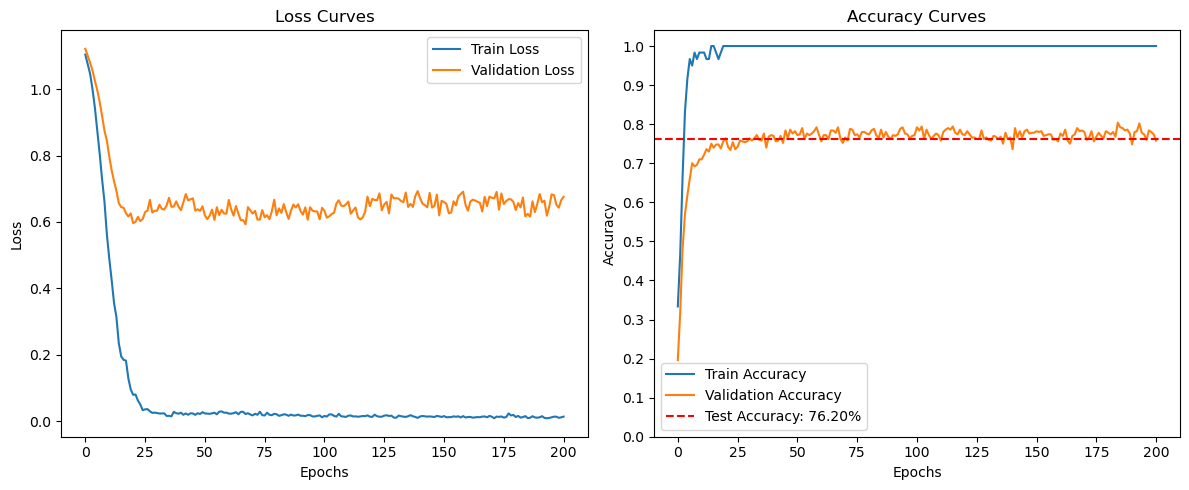

In [42]:
g_sage_gpu.fit(data.to('mps'), epochs=200)

In [43]:
g_sage_gpu.test(data.to('mps'))

0.762

## Summary of GraphSAGE

| Device  |  Train Acc  | Val Acc | Test Acc |
|:-------:|:-----------:|:-------:|:--------:|
|   CPU   |    100%     |  77.6%  |  76.4%   |
|   GPU   |    100%     |  75.8%  |  76.2%   |